In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
UnNormed_SingleTree = "DTMets"
Normed_SingleTree = "DTMetsNormd"
UnNormed_MultiTree = "DTMetsMulti"
Normed_MultiTree = "DTMetsMultiNormd"



Policy = "Policy_Captured"
Uniform = "Uniform_Captured"
Representation = "Representation"
Depth = "Depth"
Breadth = "Breadth"

domain = "_bipedal"

# Initialize an empty list to store the dictionaries
def get_data(file_name):
    data = []

    # Open the file and read each line
    with open(file_name, 'r') as file:
        for line in file:
            # Convert the line to a dictionary
            dictionary = json.loads(line.strip())  # Strip removes extra spaces or newlines
            data.append(dictionary)

    # Now, `data` is a list of dictionaries
    return data

def getMetricList(domain, method, combo_method, num_samples,metric):
    if type(num_samples) == int:
        num_samples = str(num_samples)

    filepath = method + "/" + domain + "/" + combo_method+num_samples
    data_list = get_data(filepath)
    data = []
    for i in data_list:
        data.append(i[metric])
    return data


def get_series(series, domain, tree_type, combiner, policy):
    avgs = []
    vars = []
    for i in series:
        mets = getMetricList(domain, tree_type, combiner, i, policy)
        avg = np.average(mets)
        var = np.var(mets)
        avgs.append(avg)
        vars.append(var)
    
    return (avgs, vars)


def get_comparison_Avgs(series, domain, tree_type, metric):
    mets = {}
    
    if "Multi" in tree_type:
        for i in ["Baseline", "Max_avg"]:
            mets[i] = {}
            avgs, vars = get_series(series, domain, tree_type, i, metric)
            mets[i]["Avg"] = avgs
            mets[i]["var"] = vars
        return mets
    for i in ["Baseline", "Max_avg", "Max_all", "Var_weighted"]:
        mets[i] = {}
        avgs, vars = get_series(series, domain, tree_type, i, metric)
        mets[i]["Avg"] = avgs
        mets[i]["var"] = vars
    return mets


def plot_avgs_vars(x_values, data, SIGN="MSE", label="Normalized", domain="Lunar Lander"):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row and 2 columns for side-by-side plots
    what_is_capped = "Uniform State Space"
    for key in data.keys():
        axs[0].plot(x_values, data[key]['Avg'], label=f'{key} Avg')
    axs[0].set_xlabel('Number of samples')
    axs[0].set_ylabel(f'{what_is_capped} captured {SIGN} (Avg)')
    axs[0].set_title(f'{what_is_capped} captured {SIGN} (Averages)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for 'Var'
    for key in data.keys():
        axs[1].plot(x_values, data[key]['var'], label=f'{key} Var')
    axs[1].set_xlabel('Number of samples')
    axs[1].set_ylabel(f'{what_is_capped} captured {SIGN} (Variance)')
    axs[1].set_title(f'{what_is_capped} captured {SIGN} (Variance)')
    axs[1].legend()
    axs[1].grid(True)
    fig.suptitle(f'{SIGN} of {domain} with {label} Feature Importance', fontsize=16)
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    
    save_path = f"Images/Multi_treeFD/{domain}{label}.png"
    plt.savefig(save_path)
    plt.show()



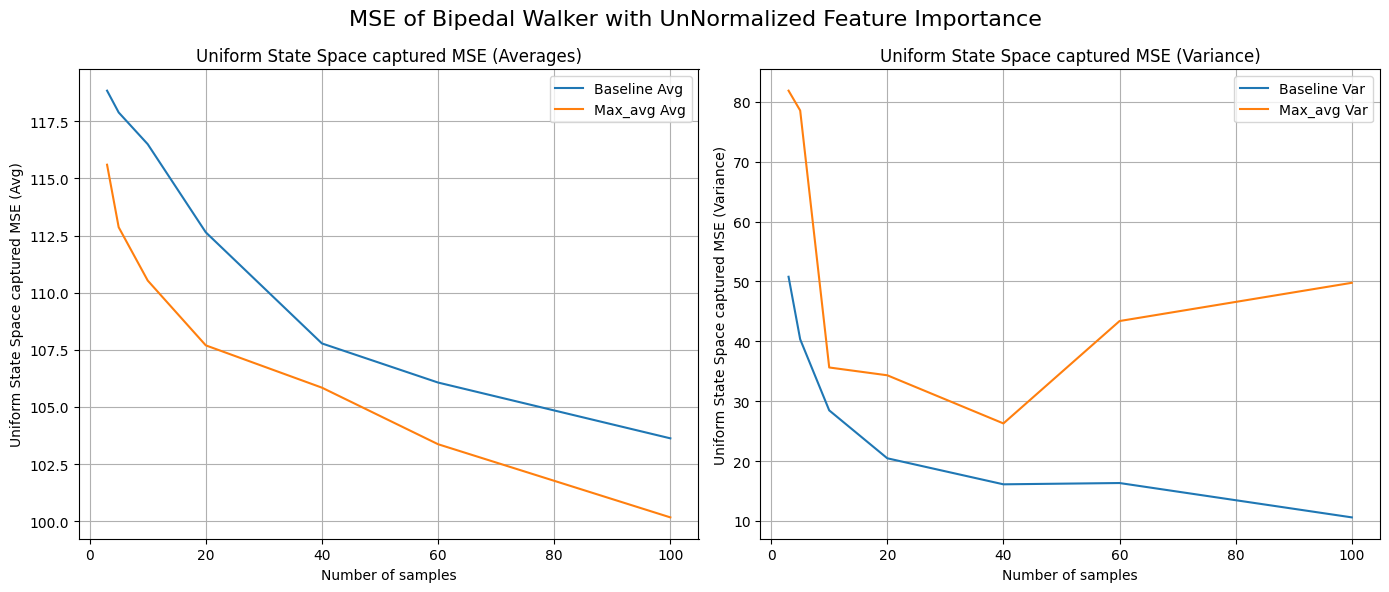

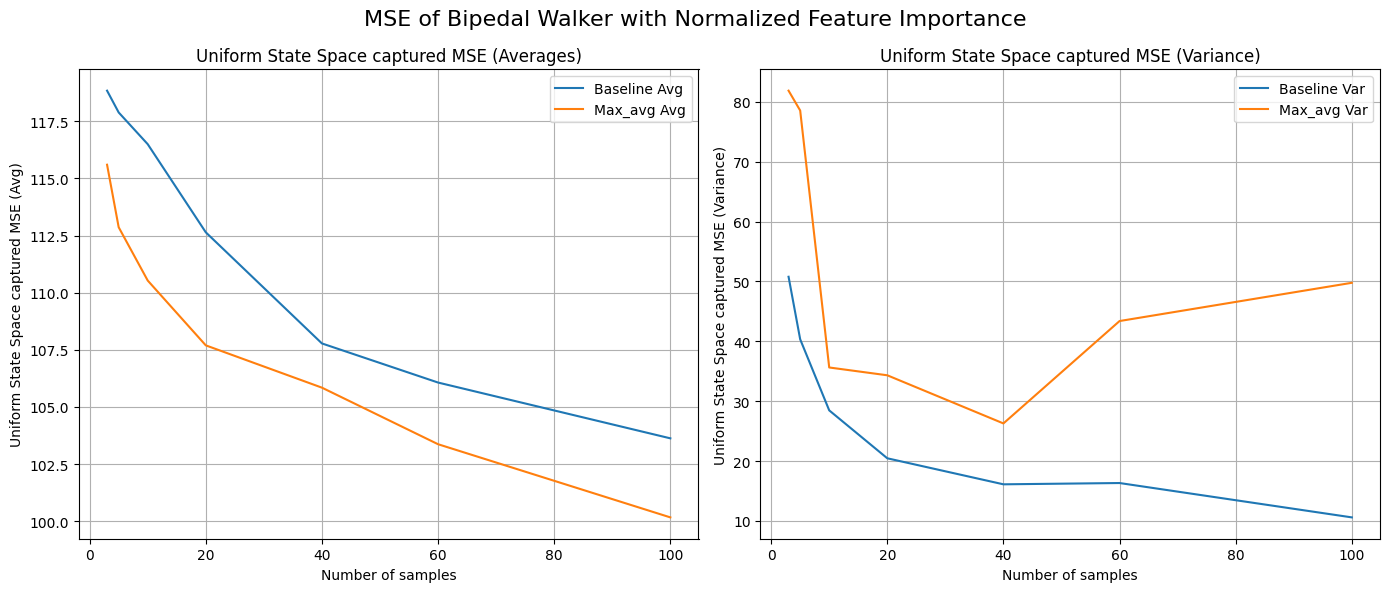

In [3]:
arr = [3,5,10,20,40,60,100]
dom = "_bipedal"
dname = "Bipedal Walker"
sign = "MSE"
# LRPLoc = "LRPMets"
mets = get_comparison_Avgs(arr, dom, UnNormed_MultiTree, Policy)
plot_avgs_vars(arr, mets, SIGN=sign, label = "UnNormalized", domain = dname)
mets = get_comparison_Avgs(arr, dom, UnNormed_MultiTree, Policy)
plot_avgs_vars(arr, mets, SIGN=sign, label = "Normalized", domain = dname)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

# Define the neural network architecture
class GaussianEstimatorNN(nn.Module):
    def __init__(self):
        super(GaussianEstimatorNN, self).__init__()
        self.input_layer = nn.Linear(2, 32)  # Input layer with 2 inputs (x, y)
        self.hidden_layer = nn.Linear(32, 32)  # Hidden layer with 32 units
        self.output_layer = nn.Linear(32, 1)  # Output layer with 2 outputs (mean for Gaussian)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        return self.output_layer(x)

# Function to generate training samples
def generate_samples(n_samples):
    x = torch.empty(n_samples, 2).uniform_(-5, 5)  # Uniform samples in [-5, 5] for x and y
    mean = torch.tensor([0.0, 0.0])
    cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # Corrected covariance matrix to be positive definite
    inv_cov = torch.inverse(cov)
    targets = torch.empty(n_samples, 2)

    for i in range(n_samples):
        diff = x[i] - mean
        exponent = -0.5 * torch.dot(diff, torch.mv(inv_cov, diff))
        pdf_value = (1 / (2 * math.pi * torch.det(cov).sqrt())) * torch.exp(exponent)
        targets[i] = torch.tensor([pdf_value, pdf_value])

    return x, targets

# Training parameters
n_samples = 1000
batch_size = 64
epochs = 50
learning_rate = 0.001

# Create the neural network, loss function, and optimizer
model = GaussianEstimatorNN().cuda() if torch.cuda.is_available() else GaussianEstimatorNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()

    # Generate the dataset
    inputs, targets = generate_samples(n_samples)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    # Split into batches
    for i in range(0, n_samples, batch_size):
        input_batch = inputs[i:i + batch_size]
        target_batch = targets[i:i + batch_size]

        # Forward pass
        output = model(input_batch)
        loss = criterion(output, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

Epoch [10/50], Loss: 0.0004
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000
Training complete!


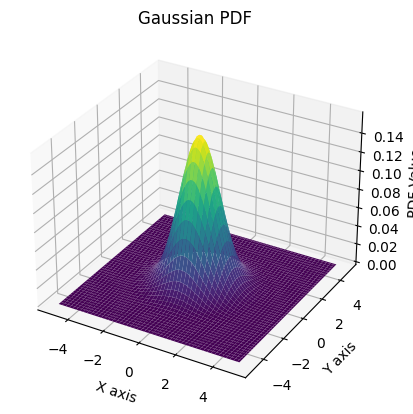

In [7]:
def plot_gaussian_pdf():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    mean = np.array([0.0, 0.0])
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = np.array([X[i, j] - mean[0], Y[i, j] - mean[1]])
            exponent = -0.5 * np.dot(diff, np.dot(inv_cov, diff))
            Z[i, j] = (1 / (2 * math.pi * math.sqrt(det_cov))) * np.exp(exponent)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('PDF Value')
    ax.set_title('Gaussian PDF')
    plt.show()

plot_gaussian_pdf()

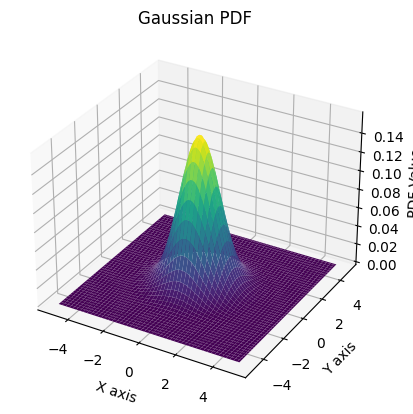

0.0065043233


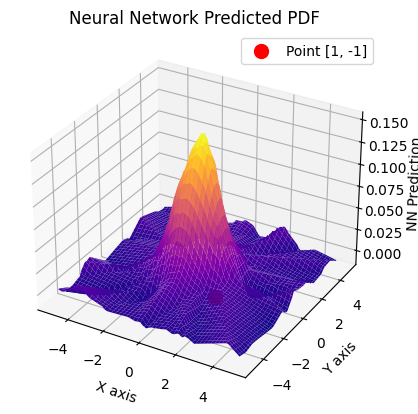

In [8]:
# Plotting the PDF in 3D
def plot_gaussian_pdf():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    mean = np.array([0.0, 0.0])
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = np.array([X[i, j] - mean[0], Y[i, j] - mean[1]])
            exponent = -0.5 * np.dot(diff, np.dot(inv_cov, diff))
            Z[i, j] = (1 / (2 * math.pi * math.sqrt(det_cov))) * np.exp(exponent)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('PDF Value')
    ax.set_title('Gaussian PDF')
    plt.show()

plot_gaussian_pdf()

def plot_nn_predictions():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the first output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

    # Adding a bright red dot at [1, -1]
    point = torch.tensor([[2, -2]], dtype=torch.float32)
    if torch.cuda.is_available():
        point = point.cuda()
    point_value = model(point).detach().cpu().numpy()[0, 0]
    print(point_value)
    ax.scatter(2, -2, point_value , color='red', s=100, label='Point [1, -1]')
    ax.set_zlim([Z.min(), Z.max()])  # Adjust Z-axis limits to ensure the point is visible
    ax.legend()

    plt.show()

plot_nn_predictions()

In [67]:
model(torch.tensor([[1.0, 1.0]], dtype=torch.float32, device="cuda")).cpu()

tensor([[0.0562, 0.0628]], grad_fn=<ToCopyBackward0>)

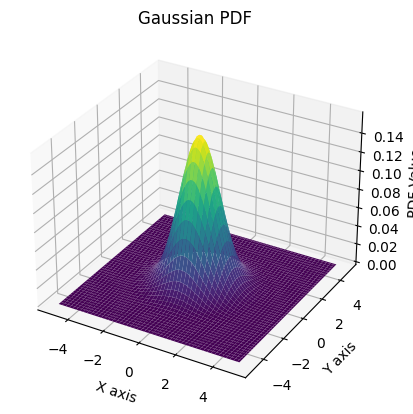

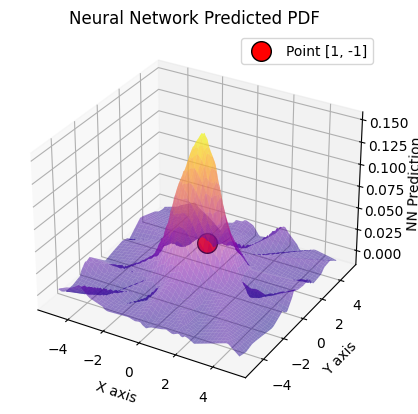

In [10]:
# Plotting the PDF in 3D
def plot_gaussian_pdf():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    mean = np.array([0.0, 0.0])
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = np.array([X[i, j] - mean[0], Y[i, j] - mean[1]])
            exponent = -0.5 * np.dot(diff, np.dot(inv_cov, diff))
            Z[i, j] = (1 / (2 * math.pi * math.sqrt(det_cov))) * np.exp(exponent)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('PDF Value')
    ax.set_title('Gaussian PDF')
    plt.show()

plot_gaussian_pdf()

# Plotting the neural network predictions in 3D
def plot_nn_predictions():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the first output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.5)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

    # Adding a bright red dot at [1, -1]
    point = torch.tensor([[1.0, -1.0]], dtype=torch.float32)
    if torch.cuda.is_available():
        point = point.cuda()
    point_value = model(point).detach().cpu().numpy()[0, 0]
    ax.scatter(1, -1, point_value, color='red', s=200, label='Point [1, -1]', edgecolors='black')
    ax.set_zlim([Z.min(), Z.max()])  # Adjust Z-axis limits to ensure the point is visible
    ax.legend()

    plt.show()

plot_nn_predictions()

In [14]:
def Relevence( x, h = .5, out_mat = True):
    with torch.no_grad():
        jac = []
        
        for i in range(x.size()[0]):
            x[i] = x[i] + h
            partial = model.forward(x)
            print(partial)
            x[i] = x[i] - 2*h
            partial = (partial - model.forward(x))/(2*h)
            x[i] = x[i] + h
            jac.append(partial.cpu().numpy())
        if out_mat:
            out = model.forward(x).cpu().numpy()
        
        jac = np.stack(jac).T
    
        if out_mat:
            return (out, jac)
        return jac

In [16]:


print(Relevence( torch.tensor([1.,-1.], dtype=torch.float32, device="cuda"), h = .5, out_mat=False))
#print(LR.get_FI(np.array([1., -1])))

tensor([0.0353, 0.0285], device='cuda:0')
tensor([0.0803, 0.0838], device='cuda:0')
[[-0.03575879  0.05576967]
 [-0.04920798  0.05464194]]


In [2]:
from FeatureImportance.methods.FiniteDifferences import FiniteDifferences
from FeatureImportance.methods.LRP import TwoDWeights_LRPModel
FD = FiniteDifferences(model)
LR = TwoDWeights_LRPModel(model)
print(FD.get_FI( np.array([[2.,-2.]]), h = .5))
print(LR.get_FI(np.array([2., -2])))

NameError: name 'model' is not defined

Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0000
Training complete!


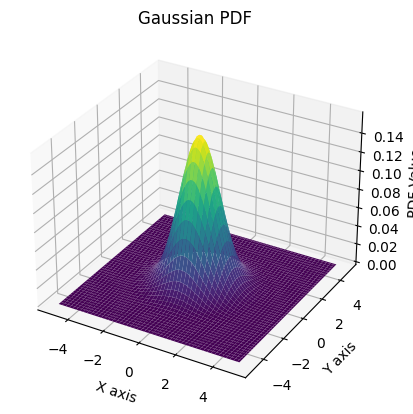

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

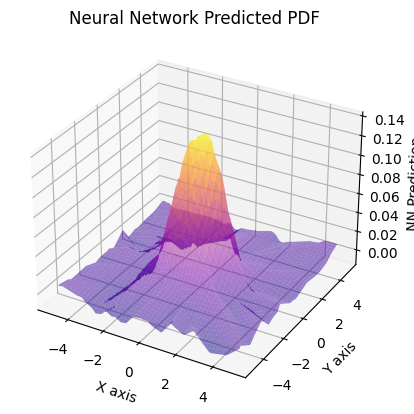

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the neural network architecture
class GaussianEstimatorNN(nn.Module):
    def __init__(self):
        super(GaussianEstimatorNN, self).__init__()
        self.input_layer = nn.Linear(2, 32)  # Input layer with 2 inputs (x, y)
        self.hidden_layer = nn.Linear(32, 32)  # Hidden layer with 32 units
        self.output_layer = nn.Linear(32, 1)  # Output layer with 1 output (PDF value)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        return self.output_layer(x)

# Function to generate training samples
def generate_samples(n_samples):
    x = torch.empty(n_samples, 2).uniform_(-5, 5)  # Uniform samples in [-5, 5] for x and y
    mean = torch.tensor([0.0, 0.0])
    cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # Corrected covariance matrix to be positive definite
    inv_cov = torch.inverse(cov)
    targets = torch.empty(n_samples, 1)

    for i in range(n_samples):
        diff = x[i] - mean
        exponent = -0.5 * torch.dot(diff, torch.mv(inv_cov, diff))
        pdf_value = (1 / (2 * math.pi * torch.det(cov).sqrt())) * torch.exp(exponent)
        targets[i] = pdf_value

    return x, targets

# Training parameters
n_samples = 1000
batch_size = 64
epochs = 50
learning_rate = 0.001

# Create the neural network, loss function, and optimizer
model = GaussianEstimatorNN().cuda() if torch.cuda.is_available() else GaussianEstimatorNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()

    # Generate the dataset
    inputs, targets = generate_samples(n_samples)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    # Split into batches
    for i in range(0, n_samples, batch_size):
        input_batch = inputs[i:i + batch_size]
        target_batch = targets[i:i + batch_size]

        # Forward pass
        output = model(input_batch)
        loss = criterion(output, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

# Plotting the PDF in 3D
def plot_gaussian_pdf():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    mean = np.array([0.0, 0.0])
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = np.array([X[i, j] - mean[0], Y[i, j] - mean[1]])
            exponent = -0.5 * np.dot(diff, np.dot(inv_cov, diff))
            Z[i, j] = (1 / (2 * math.pi * math.sqrt(det_cov))) * np.exp(exponent)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('PDF Value')
    ax.set_title('Gaussian PDF')
    plt.show()

plot_gaussian_pdf()

# Plotting the neural network predictions in 3D
def plot_nn_predictions():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.5)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

    # Adding a bright red dot at [1, -1]
    point = torch.tensor([[1.0, -1.0]], dtype=torch.float32)
    if torch.cuda.is_available():
        point = point.cuda()
    point_value = model(point).cpu().numpy()[0, 0]
    ax.scatter(1, -1, point_value, color='red', s=200, label='Point [1, -1]', edgecolors='black')
    ax.set_zlim([Z.min(), Z.max() + 1])  # Adjust Z-axis limits to ensure the point is visible
    ax.legend()

    plt.show()

plot_nn_predictions()

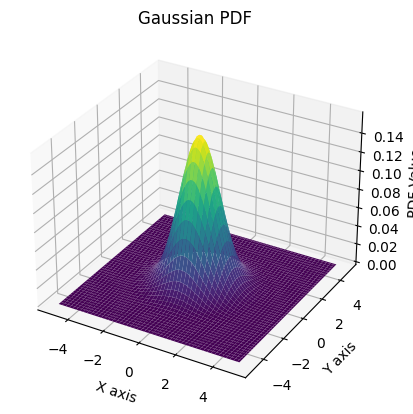

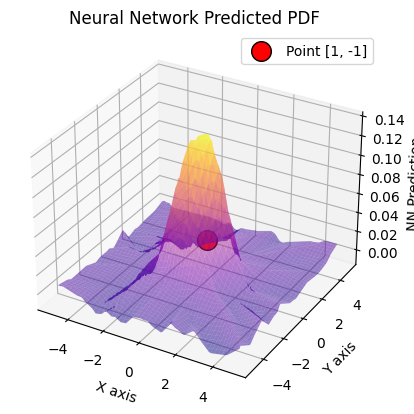

In [19]:
# Plotting the PDF in 3D
def plot_gaussian_pdf():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    mean = np.array([0.0, 0.0])
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = np.array([X[i, j] - mean[0], Y[i, j] - mean[1]])
            exponent = -0.5 * np.dot(diff, np.dot(inv_cov, diff))
            Z[i, j] = (1 / (2 * math.pi * math.sqrt(det_cov))) * np.exp(exponent)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('PDF Value')
    ax.set_title('Gaussian PDF')
    plt.show()

plot_gaussian_pdf()

# Plotting the neural network predictions in 3D
def plot_nn_predictions():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.5)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

    # Adding a bright red dot at [1, -1]
    point = torch.tensor([[1.0, -1.0]], dtype=torch.float32)
    if torch.cuda.is_available():
        point = point.cuda()
    point_value = model(point).detach().cpu().numpy()[0, 0]
    ax.scatter(1, -1, point_value, color='red', s=200, label='Point [1, -1]', edgecolors='black')
    ax.set_zlim([Z.min(), Z.max()])  # Adjust Z-axis limits to ensure the point is visible
    ax.legend()

    plt.show()

plot_nn_predictions()

In [27]:

def Relevence(x, h = .0001, out_mat = True):
    with torch.no_grad():
        jac = []
        
        for i in range(x.size()[0]):
            x[i] = x[i] + h
            partial = model.forward(x)
            x[i] = x[i] - 2*h
            partial = (partial - model.forward(x))/(2*h)
            x[i] = x[i] + h
            jac.append(partial.cpu().numpy())
        
        if out_mat:
            out = model.forward(x).cpu().numpy()
        
        jac = np.stack(jac).T
    
        if out_mat:
            return (out, jac)
        return jac

In [36]:
from FeatureImportance.methods.FiniteDifferences import FiniteDifferences
from FeatureImportance.methods.LRP import TwoDWeights_LRPModel
FD = FiniteDifferences(model)
LR = TwoDWeights_LRPModel(model)
print(Relevence( torch.tensor([1.,-1.],device="cuda"), h = 1e-5, out_mat=False)[0])
print(LR.get_FI(torch.tensor([1., -1], device="cuda"))[1][0].detach().cpu().numpy())

[-0.06016344  0.04507601]
[-0.3463245   0.39556956]


[-0.11920929, -0.08940697]
[-0.80006266, 0.80687964]


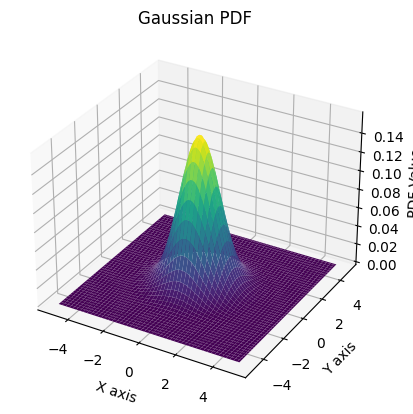

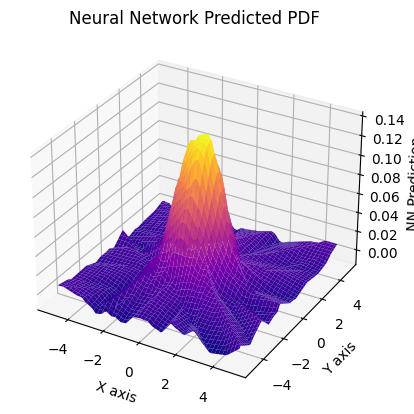

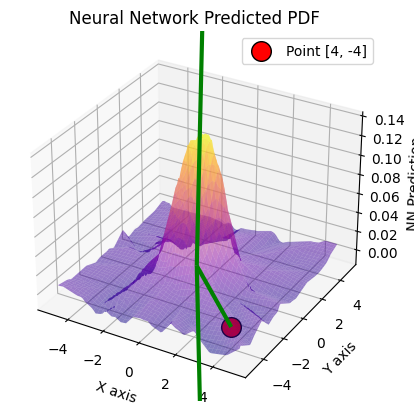

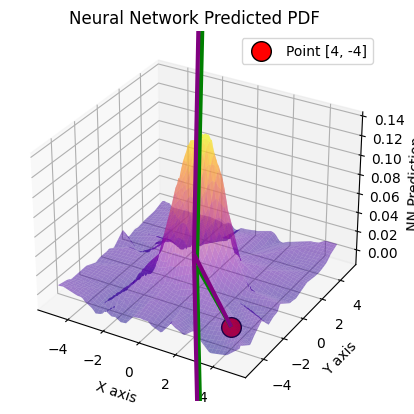

In [58]:
# Plotting the PDF in 3D
from FeatureImportance.methods.FiniteDifferences import FiniteDifferences
from FeatureImportance.methods.LRP import TwoDWeights_LRPModel
FD = FiniteDifferences(model)
LR = TwoDWeights_LRPModel(model)
POE = [4., -4]
vector_1 = list(Relevence( torch.tensor(POE,device="cuda"), h = 1e-5, out_mat=False)[0] * 5)
vector_2 = list(LR.get_FI(torch.tensor(POE, device="cuda"))[1][0].detach().cpu().numpy())

print(vector_1)
print(vector_2)
def plot_gaussian_pdf():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    mean = np.array([0.0, 0.0])
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = np.array([X[i, j] - mean[0], Y[i, j] - mean[1]])
            exponent = -0.5 * np.dot(diff, np.dot(inv_cov, diff))
            Z[i, j] = (1 / (2 * math.pi * math.sqrt(det_cov))) * np.exp(exponent)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('PDF Value')
    ax.set_title('Gaussian PDF')
    plt.show()

plot_gaussian_pdf()
def plot_nn_predictions_graph():
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the first output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

   

    plt.show()

plot_nn_predictions_graph()
# Plotting the neural network predictions in 3D
def plot_nn_predictions(vector_1):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.5)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

    # Adding a bright red dot at [1, -1]
    point = torch.tensor([POE], dtype=torch.float32)
    if torch.cuda.is_available():
        point = point.cuda()
    point_value = model(point).detach().cpu().numpy()[0, 0]
    ax.scatter(POE[0], POE[1], point_value, color='red', s=200, label='Point [4, -4]', edgecolors='black')

    # Adding vectors centered at the point [1, -1]
    origin = np.array([POE[0], POE[1], point_value])
    vector_1.append(point_value)
    vector_1 = np.array(vector_1)
    # #vector_2 = np.array([-0.3463245, 0.39556956, 0])
    
    ax.quiver(origin[0], origin[1], origin[2], 
              vector_1[0] - origin[0], vector_1[1] - origin[1], vector_1[2] - origin[2], 
              color='green', linewidth=3)
    #ax.quiver(*origin, *vector_2, color='purple', linewidth=3)

    ax.set_zlim([Z.min(), Z.max()])  # Adjust Z-axis limits to ensure the point is visible
    ax.legend()

    plt.show()

plot_nn_predictions(vector_1)

def plot_nn_predictions(vector_1, vector_2):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    model.eval()

    Z = np.zeros(X.shape)
    with torch.no_grad():
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                input_tensor = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).unsqueeze(0)
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                output = model(input_tensor).cpu().numpy()
                Z[i, j] = output[0, 0]  # Use the output as the Z value

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.5)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('NN Prediction')
    ax.set_title('Neural Network Predicted PDF')

    # Adding a bright red dot at [1, -1]
    point = torch.tensor([POE], dtype=torch.float32)
    if torch.cuda.is_available():
        point = point.cuda()
    point_value = model(point).detach().cpu().numpy()[0, 0]
    ax.scatter(POE[0], POE[1], point_value, color='red', s=200, label='Point [4, -4]', edgecolors='black')

    # Adding vectors centered at the point [1, -1]
    origin = np.array([POE[0], POE[1], point_value])
    # vector_1 = np.array([-0.06016344, 0.04507601, 0])
    vector_1.append(point_value)
    vector_1 = np.array(vector_1)
    vector_2.append(point_value)
    vector_2 = np.array(vector_2)
    #ax.quiver(*origin, *vector_1, color='green', linewidth=3)
    ax.quiver(origin[0], origin[1], origin[2], 
            vector_1[0] - origin[0], vector_1[1] - origin[1], vector_1[2] - origin[2], 
            color='green', linewidth=3)

    ax.quiver(origin[0], origin[1], origin[2], 
            vector_2[0] - origin[0], vector_2[1] - origin[1], vector_2[2] - origin[2], 
            color='purple', linewidth=3)

    ax.set_zlim([Z.min(), Z.max()])  # Adjust Z-axis limits to ensure the point is visible
    ax.legend()

    plt.show()

plot_nn_predictions(vector_1,vector_2)

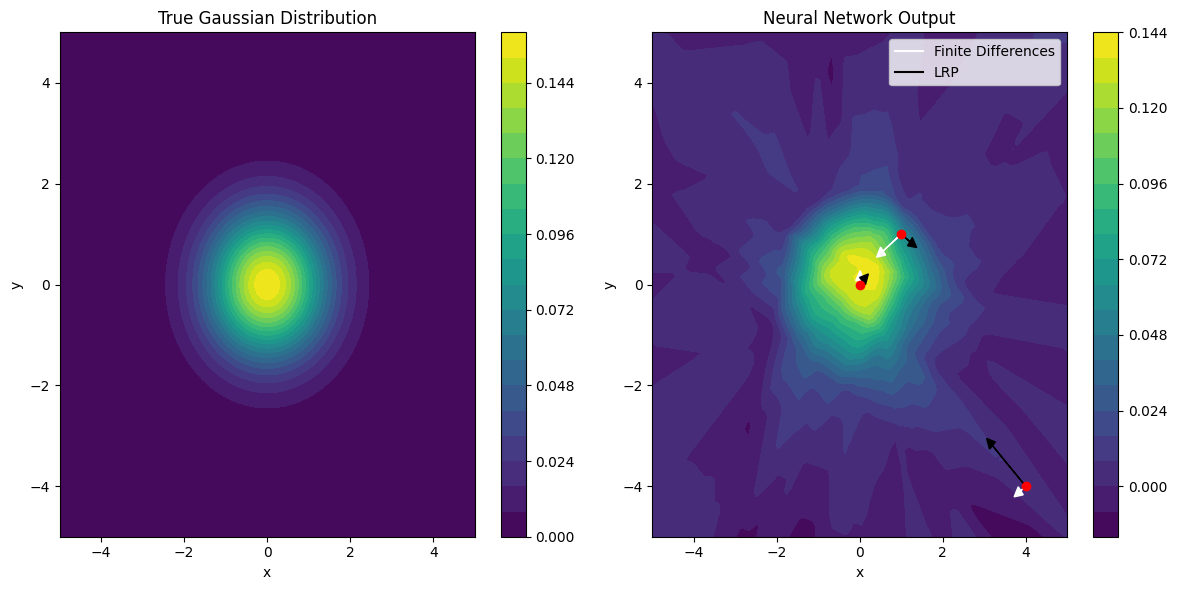

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [73]:

def gaussian_pdf(x, y, mean, cov):
    xy = np.stack([x, y], axis=-1)
    diff = xy - mean
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
    pdf_value = (1 / (2 * np.pi * np.linalg.det(cov) ** 0.5)) * np.exp(exponent)
    return pdf_value
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])

# Generate grid for the contour plot
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Generate the true Gaussian distribution contour plot
Z = gaussian_pdf(X, Y, mean, cov)

plt.figure(figsize=(12, 6))

# Plot the true Gaussian distribution
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('True Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('y')
model.eval()
X_flat = X.flatten()
Y_flat = Y.flatten()
grid_points = torch.tensor(np.stack([X_flat, Y_flat], axis=-1), dtype=torch.float32)

if torch.cuda.is_available():
    grid_points = grid_points.cuda()

with torch.no_grad():
    Z_nn = model(grid_points).cpu().numpy()

Z_nn = Z_nn.reshape(X.shape)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z_nn, levels=20, cmap='viridis')
plt.colorbar()
plt.title('Neural Network Output')
plt.xlabel('x')
plt.ylabel('y')
# Plot a point of interest (POI) as a red dot

### BEGIN PLOTTING SECTION
POI_x, POI_y = 4.0, -4.0  # Coordinates of the point of interest
plt.plot(POI_x, POI_y, 'ro')  # Red dot for POI
vector1 = np.array([-0.11920929, -0.08940697])  # First vector
vector2 = np.array([-0.80006266, 0.80687964])  # Second vector
# Plot the first vector in white
plt.arrow(POI_x, POI_y, vector1[0], vector1[1], color='white', head_width=0.2, head_length=0.2)
# Plot the second vector in grey
plt.arrow(POI_x, POI_y, vector2[0], vector2[1], color='black', head_width=0.2, head_length=0.2)

POI_x, POI_y = 1.0, 1.0  # Coordinates of the point of interest
plt.plot(POI_x, POI_y, 'ro')  # Red dot for POI
vector1 = np.array([-0.43492764, -0.33620745])  # First vector
vector2 = np.array([0.20999913, -0.14993009])  # Second vector
# Plot the first vector in white
plt.arrow(POI_x, POI_y, vector1[0], vector1[1], color='white', head_width=0.2, head_length=0.2)
# Plot the second vector in grey
plt.arrow(POI_x, POI_y, vector2[0], vector2[1], color='black', head_width=0.2, head_length=0.2)


POI_x, POI_y = 0.0, 0.0  # Coordinates of the point of interest
plt.plot(POI_x, POI_y, 'ro')  # Red dot for POI
vector1 = np.array([0.0037252903, 0.074505806])  # First vector
vector2 = np.array( [0.06858991, 0.06858991])  # Second vector
# Plot the first vector in white
plt.arrow(POI_x, POI_y, vector1[0], vector1[1], color='white', head_width=0.2, head_length=0.2)
# Plot the second vector in grey
plt.arrow(POI_x, POI_y, vector2[0], vector2[1], color='black', head_width=0.2, head_length=0.2)
plt.plot([], [], color='white', label='Finite Differences')
plt.plot([], [], color='black', label='LRP')
plt.legend()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

In [68]:
from FeatureImportance.methods.FiniteDifferences import FiniteDifferences
from FeatureImportance.methods.LRP import TwoDWeights_LRPModel
FD = FiniteDifferences(model)
LR = TwoDWeights_LRPModel(model)
POE = [0.,0.]
vector_1 = list(Relevence( torch.tensor(POE,device="cuda"), h = 1e-5, out_mat=False)[0] * 5)
vector_2 = list(LR.get_FI(torch.tensor(POE, device="cuda"))[1][0].detach().cpu().numpy())

In [69]:
print(vector_1, vector_2)

[0.0037252903, 0.074505806] [0.06858991, 0.06858991]
